In [1]:
import numpy as np
import matplotlib.pyplot as plt

class CosineWaveform:
    def __init__(self, freq, amp, phase):
        self.freq = freq
        self.amp = amp
        self.phase = phase
    def sample(self, Fs, period, timeErrorLevel = 0):
        #Added a time error level to simulate imperfect clock
        sampleTime = 1 / Fs
        timeSTD = timeErrorLevel * sampleTime
        timeErrorArray = np.array([np.random.normal(loc = 0, scale = timeSTD**2)])
        
        timeArray = np.arange(0, period, 1/Fs)
        return self.amp * np.cos(2 * np.pi * self.freq * (timeArray + timeErrorArray) + self.phase)
    
class Noise:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    def sample(self, Fs, period, timeErrorLevel = 0):
        timeArray = np.arange(0, period, 1/Fs)
        return np.array([np.random.normal(loc = self.mean, scale = self.sigma, size = None) for time in timeArray])
    
class Signal:
    def __init__(self, components):
        self.components = components
        
    def sample(self, Fs, period, timeErrorLevel = 0, quantize = False):
        waveformArray = np.array([waveform.sample(Fs, period, timeErrorLevel) for waveform in self.components])
        temp = np.zeros(waveformArray.shape[1])
        
        for waveform in waveformArray:
            temp += waveform
        if quantize:
            temp = self.Quantize12Bit(temp, Fs, period)
        return temp
    
    def Quantize12Bit(self, signal, Fs, period):
        UPPER_LIMIT = 1
        LOWER_LIMIT = -1
        binRange = UPPER_LIMIT - LOWER_LIMIT
        clippedSignal = np.clip(signal, LOWER_LIMIT, UPPER_LIMIT)
        binWidth = binRange / (2**12 - 1)
        quantized = np.round((clippedSignal - LOWER_LIMIT) / binWidth) * binWidth + LOWER_LIMIT
        return quantized
    
    @staticmethod
    def downSample(Fs, period, signal):
        sampleRatio = len(signal) / (Fs * period)
        indexArray = np.arange(0, len(signal), int(sampleRatio))
        return signal[indexArray]

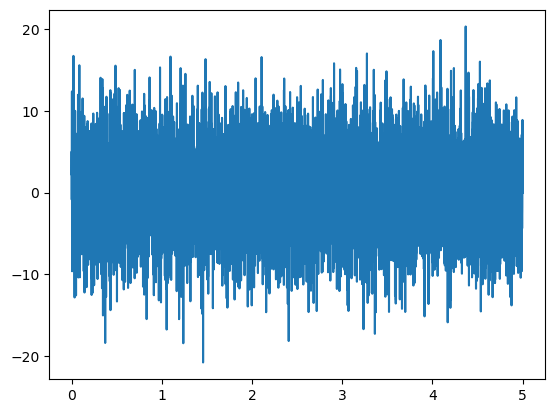

In [2]:
signal = Signal(np.array(
    [CosineWaveform(freq = 200, amp = 1, phase = 0), 
     CosineWaveform(freq = 20000, amp = 1, phase = 0), 
     Noise(mean = 0, sigma = 5)]
))

Fs = 1500
period = 5
xAxis = np.arange(0, period, 1/Fs)
yAxis = signal.sample(Fs, period)
plt.plot(xAxis, yAxis)

Text(0.5, 1.0, 'FFT Demonstration with Aliasing\nF_s = 1500 Hz')

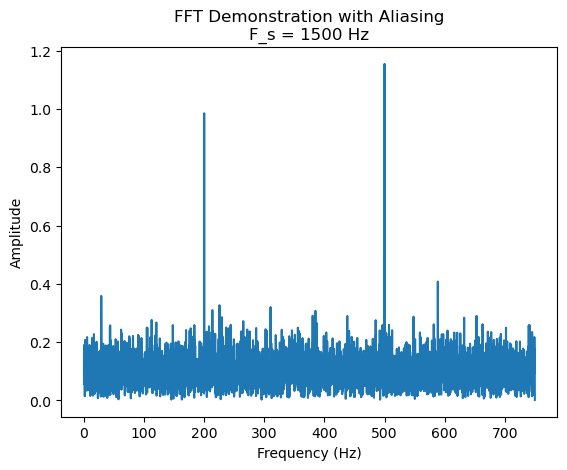

In [3]:
sampledSignal = signal.sample(Fs, period)
N = len(sampledSignal)
x = np.fft.rfft(sampledSignal)

xAxis = np.fft.rfftfreq(N, d=1/Fs)
yAxis = abs(x) / N
yAxis[1:-1] *= 2

plt.plot(xAxis, yAxis)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"FFT Demonstration with Aliasing\nF_s = {Fs} Hz")

In [4]:
#Frequency domain transfer function for a RC low pass filter circuit
def RCTransfer(omega, R, C):
    omega_rads = omega * 2 * np.pi
    return 1 / (1 + 1j * omega_rads * R * C)

def lowPassFilterRC(signal, R, C, Fs, period, timeErrorLevel = 0, quantize = False):
    sampledSignal = signal.sample(highSample, period, timeErrorLevel, quantize)
    N = len(sampledSignal)

    xAnalog = np.fft.rfft(sampledSignal)
    freq = np.fft.rfftfreq(N, d=1/highSample)
    RCWeighting = np.array([RCTransfer(iterFreq, R, C) for iterFreq in freq])

    #Multiply transfer function by orginal signal in frequency domain
    lowPassOut = xAnalog * RCWeighting
    #Inverse fourier transform
    filteredSignal = np.fft.irfft(lowPassOut)
    return filteredSignal

Text(0.5, 1.0, 'FFT Demonstration with Aliasing Removed\nF_s = 1500 Hz')

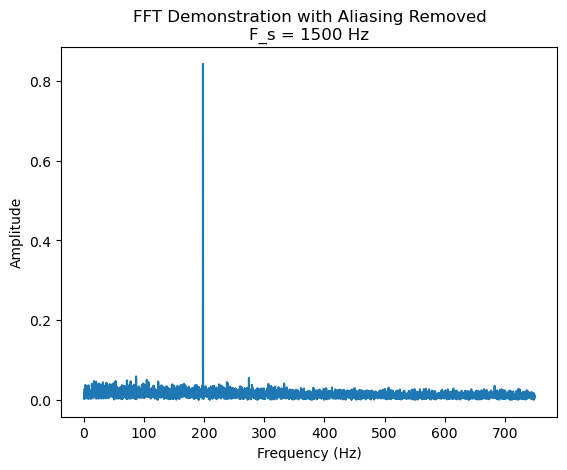

In [5]:
#Now re-sample to simulate a real digital sample of an analog filtered signal
R = 100
C = 0.000005 #5 microFarads

#Sampling high to simulate analog circuit
highSample = 50000
period = 5

filteredSignal = lowPassFilterRC(signal, R, C, highSample, period)

Fs = 1500
period = 5
downSample = Signal.downSample(Fs, period, filteredSignal)
N = len(downSample)

x = np.fft.rfft(downSample)
xAxis = np.fft.rfftfreq(N, d=1/Fs)
yAxis = abs(x) / N
yAxis[1:-1] *= 2

plt.plot(xAxis, yAxis)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"FFT Demonstration with Aliasing Removed\nF_s = {Fs} Hz")

Text(0.5, 1.0, 'FFT Demonstration with Aliasing (Realistic Signal)\nF_s = 1500 Hz')

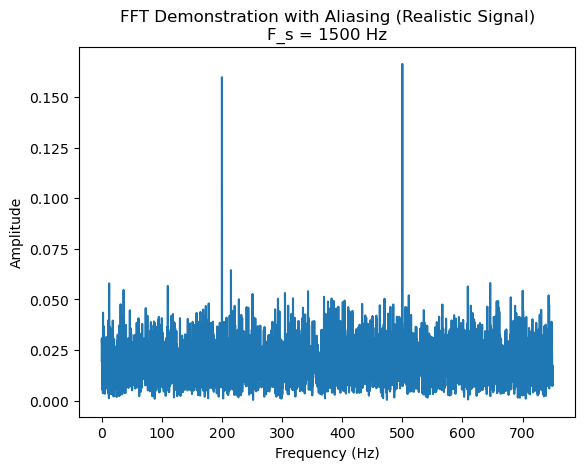

In [6]:
#adding small amplitude adjustments to demonstrate saturation
waveform = Signal(np.array([
    CosineWaveform(freq = 200, amp = 1.2, phase = 0),
    CosineWaveform(freq = 20000, amp = 1.2, phase = 0),
    Noise(mean = 0, sigma = 5)
]))

Fs = 1500
period = 5

sample = waveform.sample(Fs, period, 1 * (10**-2), quantize = True)
N = len(sample)
x = np.fft.rfft(sample)

xAxis = np.fft.rfftfreq(N, d=1/Fs)
yAxis = abs(x) / N
yAxis[1:-1] *= 2

plt.plot(xAxis, yAxis)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"FFT Demonstration with Aliasing (Realistic Signal)\nF_s = {Fs} Hz")


Text(0.5, 1.0, 'FFT Demonstration with Aliasing Removed (Realistic Signal)\nF_s = 1500 Hz')

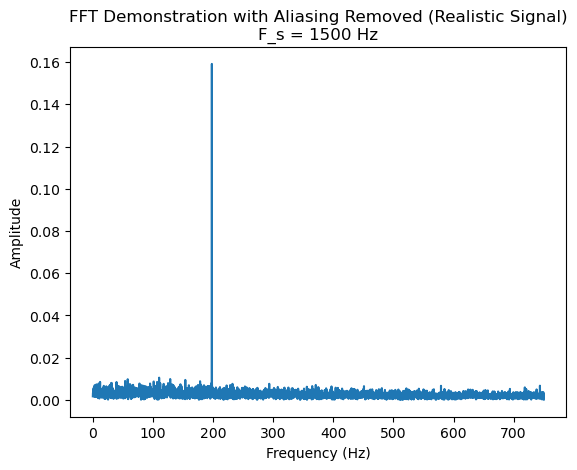

In [7]:
R = 100
C = 0.000005 #5 microFarads

highSample = 50000
period = 5

filteredSignal = lowPassFilterRC(waveform, R, C, highSample, period, 1 * (10**-2), quantize = True)

Fs = 1500
period = 5
downSample = Signal.downSample(Fs, period, filteredSignal)
N = len(downSample)

x = np.fft.rfft(downSample)
xAxis = np.fft.rfftfreq(N, d=1/Fs)
yAxis = abs(x) / N
yAxis[1:-1] *= 2

plt.plot(xAxis, yAxis)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"FFT Demonstration with Aliasing Removed (Realistic Signal)\nF_s = {Fs} Hz")